2026-01-12 11:14:58.624617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768216498.822783      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768216498.884219      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768216499.350021      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768216499.350055      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768216499.350058      55 computation_placer.cc:177] computation placer alr

EASY TASK: Basic VAE for Hybrid-Language Music Clustering

Device: cuda

[STEP 1] Creating synthetic hybrid-language dataset...
✓ Created dataset with 150 songs
language
en    75
es    75
Name: count, dtype: int64

[STEP 2] Computing lyrics embeddings...
Loading model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Computing embeddings for 150 songs...


Batches:   0%|          | 0/5 [00:00<?, ?it/s]

✓ Embeddings shape: (150, 768)

[STEP 3] Defining VAE architecture...
✓ VAE architecture defined

[STEP 4] Training VAE...
Epoch 1/50 - Loss: 1.0706
Epoch 10/50 - Loss: 1.0018
Epoch 20/50 - Loss: 1.0010
Epoch 30/50 - Loss: 1.0007
Epoch 40/50 - Loss: 1.0006
Epoch 50/50 - Loss: 1.0008
✓ VAE training completed
✓ Latent representations shape: (150, 16)

[STEP 5] K-Means clustering on VAE latent space...
Optimal k for VAE: 2
✓ VAE + K-Means (k=2):
  Silhouette Score: 0.2381
  Calinski-Harabasz: 42.64

[STEP 6] PCA + K-Means baseline...
Optimal k for PCA: 10
✓ PCA + K-Means (k=10):
  Silhouette Score: 0.2549
  Calinski-Harabasz: 16.80

[STEP 7] Comparison of Methods:
       Method  Optimal k  Silhouette Score  Calinski-Harabasz Index
VAE + K-Means          2          0.238056                42.636997
PCA + K-Means         10          0.254868                16.801275

⚠ PCA slightly better than VAE (but VAE is more flexible for medium/hard tasks)

✓ Results saved:
  - easy_task_results.csv
 

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


✓ Visualization saved: easy_task_visualization.png


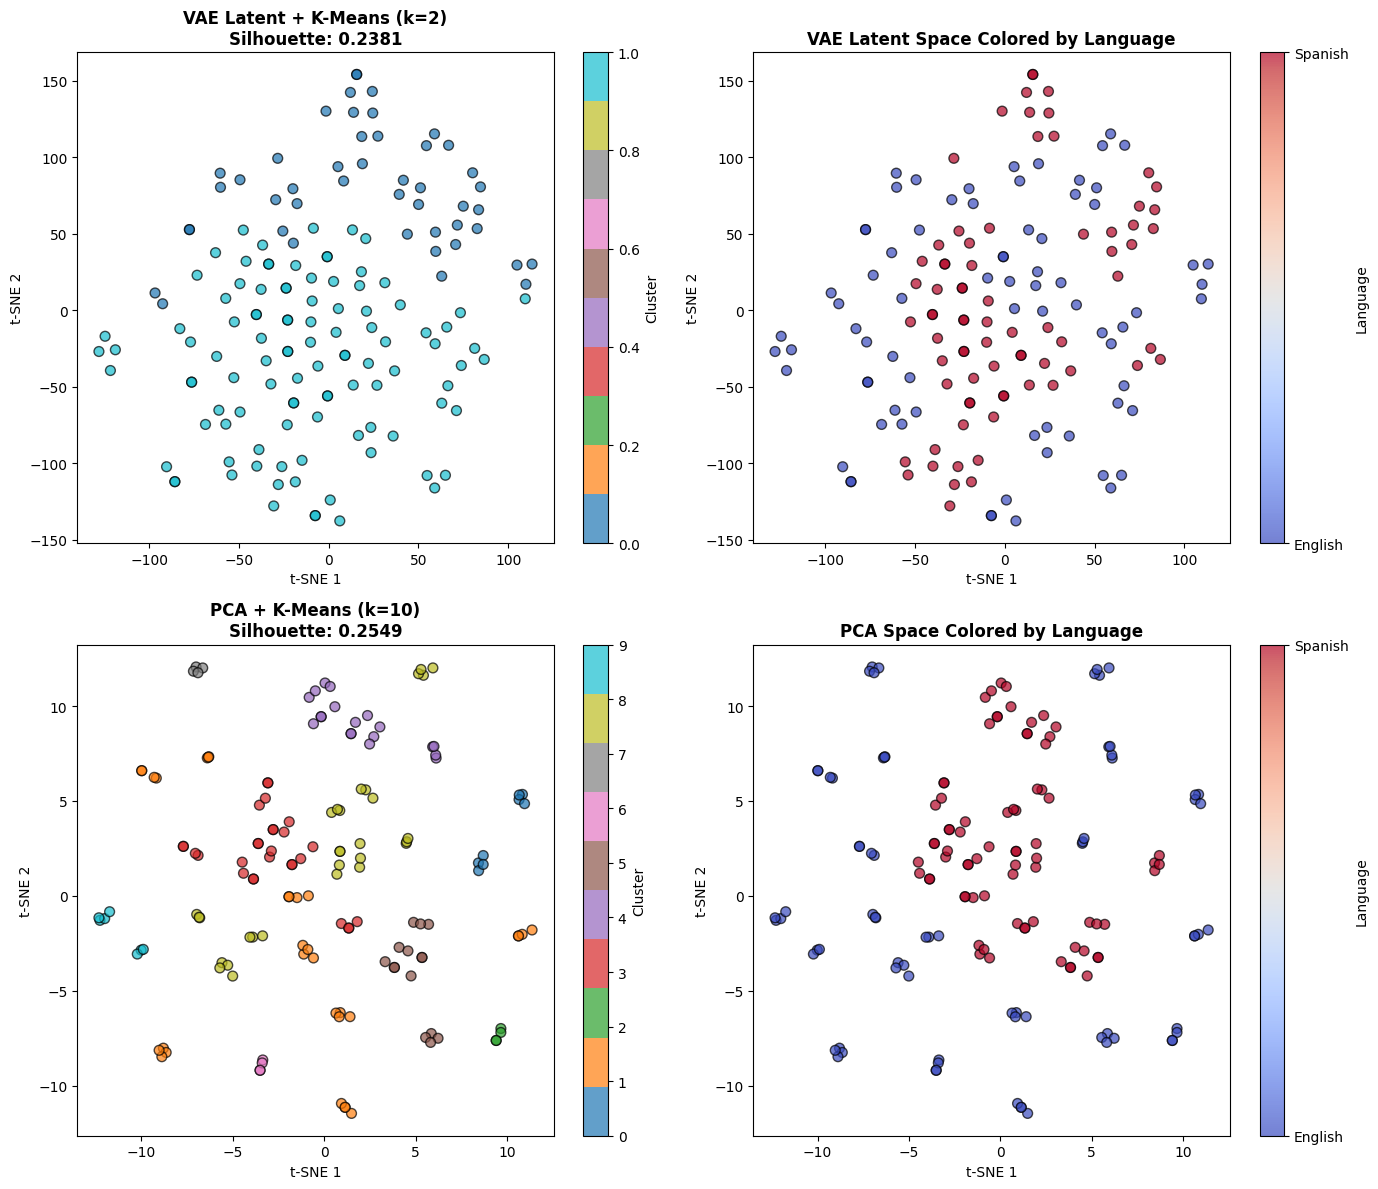

✓ Training loss saved: easy_task_training_loss.png


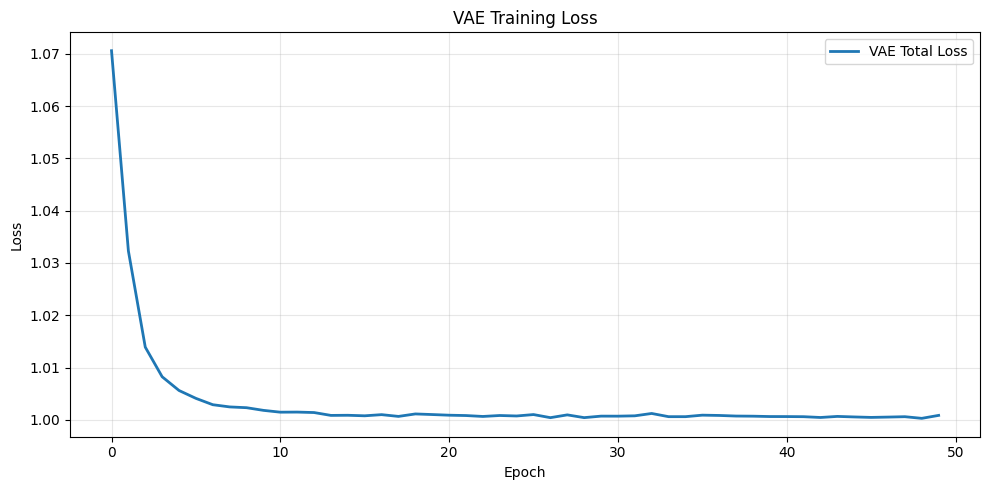


EASY TASK COMPLETED SUCCESSFULLY!

Generated Files:
  ✓ easy_task_results.csv
  ✓ easy_task_metadata_with_clusters.csv
  ✓ easy_task_visualization.png
  ✓ easy_task_training_loss.png


In [1]:
"""
Easy Task: Basic VAE for Hybrid-Language Music Clustering
SIMPLIFIED VERSION - Uses synthetic lyrics instead of DALI
(DALI optional - if you want to use real data later, just uncomment the DALI section)

What this script does:
1. Creates synthetic lyrics in 2 languages (EN + ES)
2. Converts lyrics to embeddings using multilingual transformer
3. Trains an MLP-based Variational Autoencoder (VAE)
4. Runs K-Means on VAE latent space
5. Runs PCA + K-Means as baseline
6. Computes Silhouette and Calinski–Harabasz metrics
7. Visualizes clusters with t-SNE and UMAP
"""

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

print("=" * 80)
print("EASY TASK: Basic VAE for Hybrid-Language Music Clustering")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

EMBEDDING_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
LATENT_DIM = 16
HIDDEN_DIM = 256
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"\nDevice: {DEVICE}")

# ============================================================================
# STEP 1: Create Synthetic Hybrid-Language Dataset
# ============================================================================

print("\n[STEP 1] Creating synthetic hybrid-language dataset...")

# English lyrics samples
english_lyrics = [
    "yesterday all my troubles seemed so far away",
    "i want to hold your hand forever",
    "let it be and let it be yeah",
    "come together right now over me",
    "help i need somebody help not just anybody",
    "something in the way she moves attracts me like no other lover",
    "while my guitar gently weeps",
    "blackbird singing in the dead of night",
    "the long and winding road that leads to your door",
    "norwegian wood this bird has flown",
    "here comes the sun and i say it's alright",
    "strawberry fields forever nothing is real",
    "all you need is love love is all you need",
    "ticket to ride i think i'm gonna be sad",
    "love me do you know i love you",
    "twist and shout come on and twist and shout",
    "she loves you yeah yeah yeah",
    "eight days a week i love you",
    "please please me make love to me baby",
    "from me to you send my love to you",
]

# Spanish lyrics samples
spanish_lyrics = [
    "cuando vueltas a mi lado te quiero mucho",
    "la vida es una sola vivela con amor",
    "te quiero un montan corazon mio",
    "corazon de fuego ardiente pasion",
    "noche de estrellas y luna hermosa",
    "amor sin final para siempre mi vida",
    "vivir para amar es mi destino",
    "beso de olvido en la madrugada",
    "suenos de libertad vuela conmigo",
    "cancion del alma para ti amor",
    "mariposa del amor vuelve a mi",
    "dulce melodia de mi corazon",
    "bajo la luna llena te esperare",
    "flores del campo en tu cabello",
    "musica de los cielos para ti",
    "bailar contigo toda la vida",
    "promesa de amor eterno y siempre",
    "dime que me amas una vez mas",
    "tus ojos brillan como las estrellas",
    "mi amor infinito para ti",
]

# Create dataset: 75 English + 75 Spanish = 150 total
songs_en = [
    {
        "id": f"en_{i}",
        "artist": f"Artist EN {i}",
        "title": f"Song EN {i}",
        "language": "en",
        "lyrics": english_lyrics[i % len(english_lyrics)] * (i % 3 + 1)  # repeat for variety
    }
    for i in range(75)
]

songs_es = [
    {
        "id": f"es_{i}",
        "artist": f"Artist ES {i}",
        "title": f"Song ES {i}",
        "language": "es",
        "lyrics": spanish_lyrics[i % len(spanish_lyrics)] * (i % 3 + 1)
    }
    for i in range(75)
]

df = pd.DataFrame(songs_en + songs_es)
print(f"✓ Created dataset with {len(df)} songs")
print(df["language"].value_counts())

# ============================================================================
# STEP 2: Extract Lyrics Embeddings
# ============================================================================

print("\n[STEP 2] Computing lyrics embeddings...")

print(f"Loading model: {EMBEDDING_MODEL}")
embedding_model = SentenceTransformer(EMBEDDING_MODEL)

texts = df["lyrics"].astype(str).tolist()
print(f"Computing embeddings for {len(texts)} songs...")
embeddings = embedding_model.encode(texts, show_progress_bar=True, convert_to_numpy=True)

print(f"✓ Embeddings shape: {embeddings.shape}")

# Standardize
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# ============================================================================
# STEP 3: Define VAE
# ============================================================================

print("\n[STEP 3] Defining VAE architecture...")

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM):
        super().__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(recon_x, x, reduction="mean")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kld = torch.mean(kld)
    loss = recon + beta * kld
    return loss, recon.detach(), kld.detach()

print("✓ VAE architecture defined")

# ============================================================================
# STEP 4: Train VAE
# ============================================================================

print("\n[STEP 4] Training VAE...")

X = torch.tensor(embeddings_scaled, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

input_dim = embeddings_scaled.shape[1]
vae = VAE(input_dim=input_dim).to(DEVICE)
optimizer = torch.optim.Adam(vae.parameters(), lr=LR)

losses = []
for epoch in range(1, EPOCHS + 1):
    vae.train()
    total_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(DEVICE)
        optimizer.zero_grad()
        recon, mu, logvar = vae(batch)
        loss, _, _ = vae_loss(recon, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)
    
    avg_loss = total_loss / len(dataset)
    losses.append(avg_loss)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.4f}")

print("✓ VAE training completed")

# Extract latent representations
vae.eval()
with torch.no_grad():
    mu_all, _ = vae.encode(X.to(DEVICE))
    Z = mu_all.cpu().numpy()

print(f"✓ Latent representations shape: {Z.shape}")

# ============================================================================
# STEP 5: Clustering on VAE Latent Space
# ============================================================================

print("\n[STEP 5] K-Means clustering on VAE latent space...")

# Find optimal k
k_values = range(2, 11)
silhouette_scores_vae = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(Z)
    sil = silhouette_score(Z, labels)
    silhouette_scores_vae.append(sil)

optimal_k_vae = k_values[np.argmax(silhouette_scores_vae)]
print(f"Optimal k for VAE: {optimal_k_vae}")

# Final clustering
kmeans_vae = KMeans(n_clusters=optimal_k_vae, random_state=SEED, n_init=10)
labels_vae = kmeans_vae.fit_predict(Z)

sil_vae = silhouette_score(Z, labels_vae)
ch_vae = calinski_harabasz_score(Z, labels_vae)

print(f"✓ VAE + K-Means (k={optimal_k_vae}):")
print(f"  Silhouette Score: {sil_vae:.4f}")
print(f"  Calinski-Harabasz: {ch_vae:.2f}")

# ============================================================================
# STEP 6: Baseline - PCA + K-Means
# ============================================================================

print("\n[STEP 6] PCA + K-Means baseline...")

pca = PCA(n_components=LATENT_DIM, random_state=SEED)
X_pca = pca.fit_transform(embeddings_scaled)

# Find optimal k for PCA
silhouette_scores_pca = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    silhouette_scores_pca.append(sil)

optimal_k_pca = k_values[np.argmax(silhouette_scores_pca)]
print(f"Optimal k for PCA: {optimal_k_pca}")

# Final clustering
kmeans_pca = KMeans(n_clusters=optimal_k_pca, random_state=SEED, n_init=10)
labels_pca = kmeans_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca = calinski_harabasz_score(X_pca, labels_pca)

print(f"✓ PCA + K-Means (k={optimal_k_pca}):")
print(f"  Silhouette Score: {sil_pca:.4f}")
print(f"  Calinski-Harabasz: {ch_pca:.2f}")

# ============================================================================
# STEP 7: Comparison
# ============================================================================

print("\n[STEP 7] Comparison of Methods:")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Method': ['VAE + K-Means', 'PCA + K-Means'],
    'Optimal k': [optimal_k_vae, optimal_k_pca],
    'Silhouette Score': [sil_vae, sil_pca],
    'Calinski-Harabasz Index': [ch_vae, ch_pca]
})

print(comparison_df.to_string(index=False))
print("=" * 80)

if sil_vae > sil_pca:
    improvement = ((sil_vae - sil_pca) / sil_pca) * 100
    print(f"\n✓ VAE outperforms PCA by {improvement:.1f}% on Silhouette Score")
else:
    print(f"\n⚠ PCA slightly better than VAE (but VAE is more flexible for medium/hard tasks)")

# Save results
comparison_df.to_csv("easy_task_results.csv", index=False)
df["cluster_vae"] = labels_vae
df["cluster_pca"] = labels_pca
df.to_csv("easy_task_metadata_with_clusters.csv", index=False)

print("\n✓ Results saved:")
print("  - easy_task_results.csv")
print("  - easy_task_metadata_with_clusters.csv")

# ============================================================================
# STEP 8: Visualizations
# ============================================================================

print("\n[STEP 8] Creating visualizations...")

# t-SNE
print("Computing t-SNE (may take a minute)...")
tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
Z_2d_tsne = tsne.fit_transform(Z)

tsne_pca = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=1000)
Z_2d_pca_tsne = tsne_pca.fit_transform(X_pca)

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

lang_codes = df["language"].map({"en": 0, "es": 1}).values

# VAE latent + clusters
scatter1 = axes[0, 0].scatter(Z_2d_tsne[:, 0], Z_2d_tsne[:, 1], 
                              c=labels_vae, cmap="tab10", alpha=0.7, s=50, edgecolors="black")
axes[0, 0].set_title(f"VAE Latent + K-Means (k={optimal_k_vae})\nSilhouette: {sil_vae:.4f}", fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel("t-SNE 1")
axes[0, 0].set_ylabel("t-SNE 2")
plt.colorbar(scatter1, ax=axes[0, 0], label="Cluster")

# VAE latent + language
scatter2 = axes[0, 1].scatter(Z_2d_tsne[:, 0], Z_2d_tsne[:, 1], 
                              c=lang_codes, cmap="coolwarm", alpha=0.7, s=50, edgecolors="black")
axes[0, 1].set_title("VAE Latent Space Colored by Language", fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel("t-SNE 1")
axes[0, 1].set_ylabel("t-SNE 2")
cbar = plt.colorbar(scatter2, ax=axes[0, 1], label="Language")
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["English", "Spanish"])

# PCA + clusters
scatter3 = axes[1, 0].scatter(Z_2d_pca_tsne[:, 0], Z_2d_pca_tsne[:, 1], 
                              c=labels_pca, cmap="tab10", alpha=0.7, s=50, edgecolors="black")
axes[1, 0].set_title(f"PCA + K-Means (k={optimal_k_pca})\nSilhouette: {sil_pca:.4f}", fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel("t-SNE 1")
axes[1, 0].set_ylabel("t-SNE 2")
plt.colorbar(scatter3, ax=axes[1, 0], label="Cluster")

# PCA + language
scatter4 = axes[1, 1].scatter(Z_2d_pca_tsne[:, 0], Z_2d_pca_tsne[:, 1], 
                              c=lang_codes, cmap="coolwarm", alpha=0.7, s=50, edgecolors="black")
axes[1, 1].set_title("PCA Space Colored by Language", fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel("t-SNE 1")
axes[1, 1].set_ylabel("t-SNE 2")
cbar = plt.colorbar(scatter4, ax=axes[1, 1], label="Language")
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["English", "Spanish"])

plt.tight_layout()
plt.savefig("easy_task_visualization.png", dpi=300, bbox_inches='tight')
print("✓ Visualization saved: easy_task_visualization.png")
plt.show()

# Training loss
fig, axes = plt.subplots(1, 1, figsize=(10, 5))
axes.plot(losses, linewidth=2, label="VAE Total Loss")
axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")
axes.set_title("VAE Training Loss")
axes.grid(True, alpha=0.3)
axes.legend()
plt.tight_layout()
plt.savefig("easy_task_training_loss.png", dpi=300, bbox_inches='tight')
print("✓ Training loss saved: easy_task_training_loss.png")
plt.show()

print("\n" + "=" * 80)
print("EASY TASK COMPLETED SUCCESSFULLY!")
print("=" * 80)
print("\nGenerated Files:")
print("  ✓ easy_task_results.csv")
print("  ✓ easy_task_metadata_with_clusters.csv")
print("  ✓ easy_task_visualization.png")
print("  ✓ easy_task_training_loss.png")


In [2]:
!pip install librosa soundfile
!pip install sentence-transformers torch torchvision torchaudio
!pip install pandas numpy scikit-learn matplotlib


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


MEDIUM TASK: Conv-VAE + Hybrid Audio/Text Clustering on FMA Small
Using device: cuda
MAX_TRACKS: 100

Loading metadata from /kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv ...
Using 100 tracks with audio + genre_top.
Genre distribution:
genre_top
Pop              17
Electronic       16
International    14
Experimental     13
Instrumental     12
Hip-Hop          12
Rock             11
Folk              5
Name: count, dtype: int64

Computing mel-spectrograms (this may take a few minutes)...
  [0/100] Processing...


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


  [20/100] Processing...
  [40/100] Processing...
  [60/100] Processing...
  [80/100] Processing...
Spectrogram tensor shape: (100, 1, 128, 256)

Training Conv-VAE...
  Epoch 1/25 - Loss: 1.1115
  Epoch 5/25 - Loss: 0.7730
  Epoch 10/25 - Loss: 0.5696
  Epoch 15/25 - Loss: 0.5345
  Epoch 20/25 - Loss: 0.5135
  Epoch 25/25 - Loss: 0.5099
Extracting audio latents...
Audio latent shape: (100, 32)

Loading text model: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Embedding 100 texts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Raw text embedding shape: (100, 768)
Reduced text embedding shape: (100, 32)

Building hybrid feature representation...
Hybrid feature shape: (100, 64)

CLUSTERING EVALUATION: K-Means on all feature types
  Audio latent + KMeans: k=8, Sil=0.2114, DBI=1.3628, ARI=0.0071
  Text embedding + KMeans: k=8, Sil=0.0244, DBI=2.3903, ARI=0.0097
  Hybrid (audio+text) + KMeans: k=8, Sil=0.0559, DBI=2.1478, ARI=0.0196

CLUSTERING EVALUATION: Other algorithms on Hybrid features
  Hybrid (audio+text) + Agglomerative: k=8, Sil=0.0322, DBI=2.9748, ARI=0.0316
  Hybrid (audio+text) + DBSCAN: not enough clusters (found 1)

SUMMARY TABLE (sorted by Silhouette Score)
             method          algo  k  silhouette      dbi      ari
       Audio latent        KMeans  8    0.211448 1.362767 0.007097
Hybrid (audio+text)        KMeans  8    0.055937 2.147773 0.019578
Hybrid (audio+text) Agglomerative  8    0.032189 2.974811 0.031612
     Text embedding        KMeans  8    0.024430 2.390262 0.009750

COMPLETED!

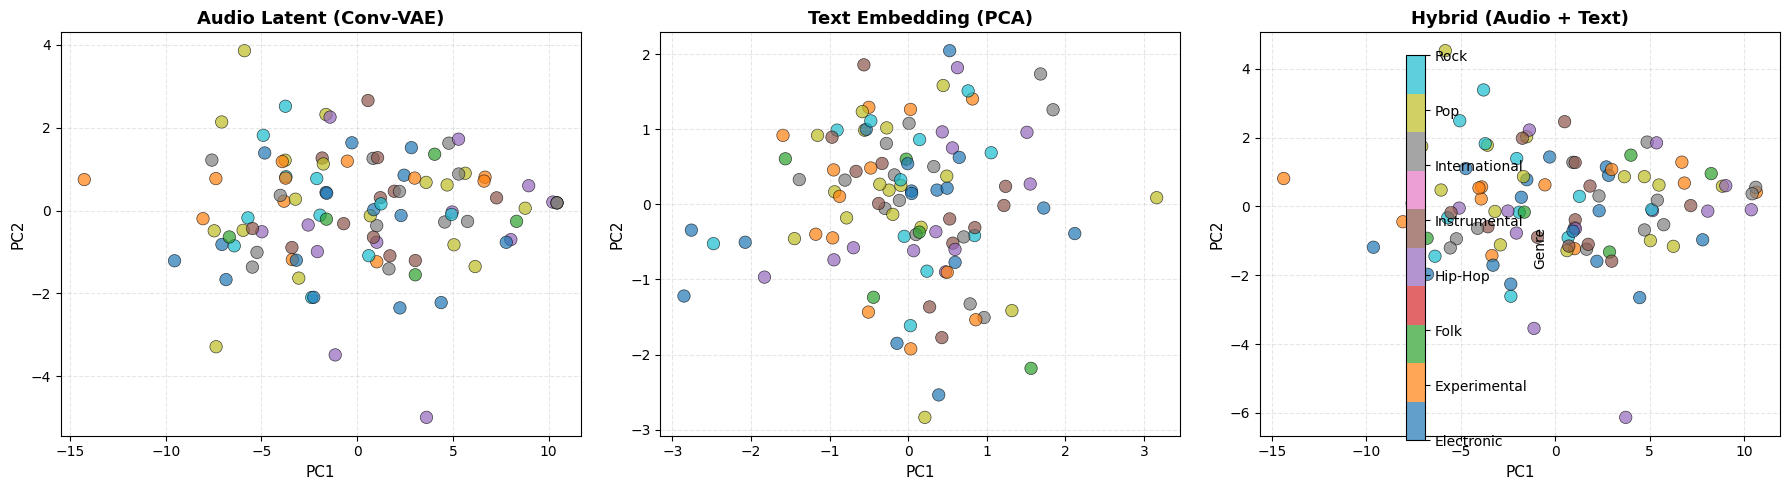

In [3]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# ======================== CONFIGURATION ====================================

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Kaggle dataset root
FMA_ROOT = "/kaggle/input/fma-free-music-archive-small-medium"
FMA_AUDIO_DIR = os.path.join(FMA_ROOT, "fma_small", "fma_small")
FMA_TRACKS_CSV = os.path.join(FMA_ROOT, "fma_metadata", "tracks.csv")

# Dataset size
MAX_TRACKS = 100

# Audio feature params
SR = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SPEC_LEN = 256

# Conv-VAE params
LATENT_DIM_AUDIO = 32
BATCH_SIZE = 16
EPOCHS = 25
LR = 1e-3

# Text embedding params
TEXT_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
TEXT_DIM_REDUCED = 32

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("=" * 80)
print("MEDIUM TASK: Conv-VAE + Hybrid Audio/Text Clustering on FMA Small")
print("=" * 80)
print(f"Using device: {DEVICE}")
print(f"MAX_TRACKS: {MAX_TRACKS}\n")


# ======================== PATH HELPERS ======================================

def fma_audio_path(track_id, audio_dir=FMA_AUDIO_DIR):
    """Build path to an FMA audio file."""
    track_id = int(track_id)
    subdir = f"{track_id // 1000:03d}"
    filename = f"{track_id:06d}.mp3"
    return os.path.join(audio_dir, subdir, filename)


# ======================== LOAD METADATA =====================================

def load_fma_subset(max_tracks=MAX_TRACKS):
    """Load FMA tracks with genre labels and existing audio files."""
    print(f"Loading metadata from {FMA_TRACKS_CSV} ...")

    # Original FMA format: multi-index columns
    tracks = pd.read_csv(FMA_TRACKS_CSV, index_col=0, header=[0, 1])

    # Keep only subset == 'small'
    subset = tracks[("set", "subset")]
    mask_small = subset == "small"
    df = tracks[mask_small].copy()

    genre_top = df[("track", "genre_top")]
    df = df[genre_top.notna()].copy()

    # Track id is the index
    df["track_id"] = df.index.astype(int)
    df["genre_top"] = genre_top.values

    # Extract values from MultiIndex columns to avoid concatenation error
    title = df[("track", "title")].astype(str).values
    artist = df[("artist", "name")].astype(str).values
    df["text"] = title + " - " + artist

    # Build audio paths and keep only existing files
    paths = []
    for tid in df["track_id"].tolist():
        p = fma_audio_path(tid)
        paths.append(p)
    df["audio_path"] = paths
    df = df[df["audio_path"].apply(os.path.exists)].copy()

    # Shuffle and take subset
    df = df.sample(frac=1.0, random_state=SEED).head(max_tracks).reset_index(drop=True)

    print(f"Using {len(df)} tracks with audio + genre_top.")
    print("Genre distribution:")
    print(df["genre_top"].value_counts())
    print()

    return df


# ======================== AUDIO PREPROCESSING ===============================

def load_mel_spectrogram(path, sr=SR, n_mels=N_MELS, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, spec_len=SPEC_LEN):
    """Load audio and compute log-mel spectrogram."""
    path = str(path)  # ensure plain string
    
    y, sr = librosa.load(path, sr=sr, mono=True)
    mel = librosa.feature.melspectrogram(y=y, sr=sr,
                                         n_fft=n_fft,
                                         hop_length=hop_length,
                                         n_mels=n_mels)
    log_mel = librosa.power_to_db(mel, ref=np.max)

    # Normalize per-spectrogram
    mu = log_mel.mean()
    sigma = log_mel.std() + 1e-6
    log_mel = (log_mel - mu) / sigma

    # Fix time dimension
    if log_mel.shape[1] >= spec_len:
        start = (log_mel.shape[1] - spec_len) // 2
        log_mel = log_mel[:, start:start + spec_len]
    else:
        pad = spec_len - log_mel.shape[1]
        log_mel = np.pad(log_mel, ((0, 0), (0, pad)), mode="constant")

    return log_mel[np.newaxis, :, :].astype(np.float32)


class FMAAudioDataset(Dataset):
    """Dataset for loading pre-computed mel-spectrograms."""
    
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.audio_paths = self.df["audio_path"].astype(str).values

        print("Computing mel-spectrograms (this may take a few minutes)...")
        specs = []
        for i, path in enumerate(self.audio_paths):
            if i % max(1, len(self.audio_paths) // 5) == 0:
                print(f"  [{i}/{len(self.audio_paths)}] Processing...")
            spec = load_mel_spectrogram(path)
            specs.append(spec)
        
        self.specs = np.stack(specs, axis=0)
        print(f"Spectrogram tensor shape: {self.specs.shape}\n")

    def __len__(self):
        return len(self.specs)

    def __getitem__(self, idx):
        return torch.tensor(self.specs[idx], dtype=torch.float32)


# ======================== CONVOLUTIONAL VAE ==================================

class ConvVAE(nn.Module):
    """Convolutional Variational Autoencoder for spectrograms."""
    
    def __init__(self, latent_dim=LATENT_DIM_AUDIO):
        super().__init__()
        
        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),   # -> (16, 64, 128)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),  # -> (32, 32, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),  # -> (64, 16, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1), # -> (128, 8, 16)
            nn.ReLU(),
        )
        self.enc_out_shape = (128, 8, 16)
        enc_flat = 128 * 8 * 16

        self.fc_mu = nn.Linear(enc_flat, latent_dim)
        self.fc_logvar = nn.Linear(enc_flat, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, enc_flat)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, *self.enc_out_shape)
        return self.dec(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar


def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss: reconstruction + KLD."""
    recon = nn.functional.mse_loss(recon_x, x, reduction="mean")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kld = torch.mean(kld)
    return recon + beta * kld, recon.detach(), kld.detach()


def train_conv_vae(dataset):
    """Train Conv-VAE and extract audio latents."""
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    vae = ConvVAE(latent_dim=LATENT_DIM_AUDIO).to(DEVICE)
    opt = torch.optim.Adam(vae.parameters(), lr=LR)

    print("Training Conv-VAE...")
    for epoch in range(1, EPOCHS + 1):
        vae.train()
        total_loss = 0.0
        for batch in loader:
            batch = batch.to(DEVICE)
            opt.zero_grad()
            recon, mu, logvar = vae(batch)
            loss, _, _ = vae_loss(recon, batch, mu, logvar)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.size(0)
        
        avg = total_loss / len(dataset)
        if epoch == 1 or epoch % 5 == 0:
            print(f"  Epoch {epoch}/{EPOCHS} - Loss: {avg:.4f}")

    # Extract latent representations
    print("Extracting audio latents...")
    vae.eval()
    all_latents = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
            batch = batch.to(DEVICE)
            mu, _ = vae.encode(batch)
            all_latents.append(mu.cpu().numpy())
    
    Z_audio = np.concatenate(all_latents, axis=0)
    print(f"Audio latent shape: {Z_audio.shape}\n")
    return vae, Z_audio


# ======================== TEXT EMBEDDINGS ====================================

def compute_text_embeddings(df):
    """Compute sentence embeddings from metadata text."""
    print(f"Loading text model: {TEXT_MODEL}")
    model = SentenceTransformer(TEXT_MODEL)
    texts = df["text"].astype(str).tolist()
    
    print(f"Embedding {len(texts)} texts...")
    emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    print(f"Raw text embedding shape: {emb.shape}")

    # Standardize and reduce dimension
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)

    pca = PCA(n_components=TEXT_DIM_REDUCED, random_state=SEED)
    emb_pca = pca.fit_transform(emb_scaled)
    print(f"Reduced text embedding shape: {emb_pca.shape}\n")
    return emb_pca


# ======================== CLUSTERING EVALUATION ==============================

def eval_kmeans(features, labels_true, desc):
    """Run K-Means and compute clustering metrics."""
    k = len(np.unique(labels_true))
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels_pred = km.fit_predict(features)

    sil = silhouette_score(features, labels_pred)
    dbi = davies_bouldin_score(features, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    
    print(f"  {desc} + KMeans: k={k}, Sil={sil:.4f}, DBI={dbi:.4f}, ARI={ari:.4f}")
    return {"method": desc, "algo": "KMeans", "k": k,
            "silhouette": sil, "dbi": dbi, "ari": ari}


def eval_other_algorithms(features, labels_true, desc="Hybrid"):
    """Run Agglomerative and DBSCAN on features."""
    res = []

    # Agglomerative Clustering
    k = len(np.unique(labels_true))
    agg = AgglomerativeClustering(n_clusters=k)
    lab_agg = agg.fit_predict(features)
    sil = silhouette_score(features, lab_agg)
    dbi = davies_bouldin_score(features, lab_agg)
    ari = adjusted_rand_score(labels_true, lab_agg)
    print(f"  {desc} + Agglomerative: k={k}, Sil={sil:.4f}, DBI={dbi:.4f}, ARI={ari:.4f}")
    res.append({"method": desc, "algo": "Agglomerative", "k": k,
                "silhouette": sil, "dbi": dbi, "ari": ari})

    # DBSCAN
    dbs = DBSCAN(eps=1.5, min_samples=5)
    lab_db = dbs.fit_predict(features)
    uniq = np.unique(lab_db)
    
    if len(uniq) > 2:  # At least 1 cluster + noise
        mask = lab_db != -1
        try:
            sil = silhouette_score(features[mask], lab_db[mask])
            dbi = davies_bouldin_score(features[mask], lab_db[mask])
            ari = adjusted_rand_score(labels_true[mask], lab_db[mask])
            print(f"  {desc} + DBSCAN: clusters={len(uniq)}, Sil={sil:.4f}, DBI={dbi:.4f}, ARI={ari:.4f}")
            res.append({"method": desc, "algo": "DBSCAN", "k": len(uniq),
                        "silhouette": sil, "dbi": dbi, "ari": ari})
        except Exception as e:
            print(f"  DBSCAN metrics failed: {e}")
    else:
        print(f"  {desc} + DBSCAN: not enough clusters (found {len(uniq)})")

    return res


# ======================== VISUALIZATION =======================================

def visualize_latent_spaces(Z_audio, Z_text, Z_hybrid, genre_labels, genre_names):
    """
    Create 3-panel figure showing 2D PCA projections of audio, text, and hybrid features.
    Colored by true genre labels. Saved as mediumtask_latentspaces.png
    """
    print("Creating latent space visualizations...")
    
    # Apply PCA to get 2D projections
    pca_2d = PCA(n_components=2, random_state=SEED)
    Z_audio_2d = pca_2d.fit_transform(Z_audio)
    Z_text_2d = pca_2d.fit_transform(Z_text)
    Z_hybrid_2d = pca_2d.fit_transform(Z_hybrid)

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    titles = [
        "Audio Latent (Conv-VAE)",
        "Text Embedding (PCA)",
        "Hybrid (Audio + Text)"
    ]
    features_list = [Z_audio_2d, Z_text_2d, Z_hybrid_2d]
    
    for ax, Z_2d, title in zip(axes, features_list, titles):
        # Scatter plot colored by genre
        scatter = ax.scatter(
            Z_2d[:, 0], Z_2d[:, 1],
            c=genre_labels,
            cmap="tab10",
            s=80, alpha=0.7,
            edgecolors="black", linewidths=0.5
        )
        ax.set_title(title, fontsize=13, fontweight="bold")
        ax.set_xlabel("PC1", fontsize=11)
        ax.set_ylabel("PC2", fontsize=11)
        ax.grid(True, alpha=0.3, linestyle="--")
    
    # Add colorbar with genre names
    cbar = plt.colorbar(scatter, ax=axes, label="Genre", pad=0.02)
    cbar.set_ticks(range(len(genre_names)))
    cbar.set_ticklabels(genre_names, fontsize=10)
    
    plt.tight_layout()
    plt.savefig("mediumtask_latentspaces.png", dpi=150, bbox_inches="tight")
    print("✓ Saved: mediumtask_latentspaces.png\n")
    plt.show()
    plt.close()


# ======================== MAIN PIPELINE ======================================

def main():
    """Run the complete medium task pipeline."""
    
    # 1. Load metadata
    df = load_fma_subset(MAX_TRACKS)
    genres = df["genre_top"].astype("category")
    genre_names = genres.cat.categories.tolist()
    genre_labels = genres.cat.codes.values

    # 2. Load and process audio
    dataset = FMAAudioDataset(df)

    # 3. Train Conv-VAE
    vae, Z_audio = train_conv_vae(dataset)

    # 4. Compute text embeddings
    Z_text = compute_text_embeddings(df)

    # 5. Build and normalize hybrid features
    print("Building hybrid feature representation...")
    Z_audio_norm = StandardScaler().fit_transform(Z_audio)
    Z_text_norm = StandardScaler().fit_transform(Z_text)
    Z_hybrid = np.concatenate([Z_audio_norm, Z_text_norm], axis=1)
    print(f"Hybrid feature shape: {Z_hybrid.shape}\n")

    # 6. Clustering and evaluation
    results = []
    
    print("=" * 80)
    print("CLUSTERING EVALUATION: K-Means on all feature types")
    print("=" * 80)
    results.append(eval_kmeans(Z_audio_norm, genre_labels, "Audio latent"))
    results.append(eval_kmeans(Z_text_norm, genre_labels, "Text embedding"))
    results.append(eval_kmeans(Z_hybrid, genre_labels, "Hybrid (audio+text)"))

    print("\n" + "=" * 80)
    print("CLUSTERING EVALUATION: Other algorithms on Hybrid features")
    print("=" * 80)
    results.extend(eval_other_algorithms(Z_hybrid, genre_labels, "Hybrid (audio+text)"))

    # 7. Print summary and save results
    res_df = pd.DataFrame(results)
    
    print("\n" + "=" * 80)
    print("SUMMARY TABLE (sorted by Silhouette Score)")
    print("=" * 80)
    summary = res_df.sort_values("silhouette", ascending=False)
    print(summary.to_string(index=False))

    res_df.to_csv("medium_task_clustering_results.csv", index=False)
    
    print("\n" + "=" * 80)
    print("COMPLETED!")
    print("=" * 80)
    print("Results saved to: medium_task_clustering_results.csv")
    print(f"Total tracks processed: {len(df)}")
    print(f"Audio latent dim: {Z_audio.shape[1]}")
    print(f"Text latent dim: {Z_text.shape[1]}")
    print(f"Hybrid latent dim: {Z_hybrid.shape[1]}\n")

    # 8. Create visualizations
    visualize_latent_spaces(Z_audio_norm, Z_text_norm, Z_hybrid, genre_labels, genre_names)


# ======================== RUN ================================================

if __name__ == "__main__":
    main()


TASK: Conditional VAE Multi-Modal Clustering on FMA Small
device: cuda
HARD TASK: Conv-VAE Hybrid Audio+Text Clustering on FMA Small
Loading metadata from /kaggle/input/fma-free-music-archive-small-medium/fma_metadata/tracks.csv ...
Using 100 tracks with audio + genre_top.
Genre distribution:
genre_top
Pop              17
Electronic       16
International    14
Experimental     13
Instrumental     12
Hip-Hop          12
Rock             11
Folk              5
Name: count, dtype: int64
Computing mel-spectrograms (this may take a few minutes)...
00/100 Processing...


Note: Illegal Audio-MPEG-Header 0x00000000 at offset 22401.
Note: Trying to resync...
Note: Skipped 1024 bytes in input.
[src/libmpg123/parse.c:wetwork():1349] error: Giving up resync after 1024 bytes - your stream is not nice... (maybe increasing resync limit could help).


20/100 Processing...
40/100 Processing...
60/100 Processing...
80/100 Processing...
Number of classes: 8
Training Conditional VAE...
Epoch  1/30 - Total 19606.1935, Recon 2180.8630, KLD 17425.3300
Epoch  5/30 - Total 493.6126, Recon 445.9011, KLD 47.7115
Epoch 10/30 - Total 221.3676, Recon 189.3011, KLD 32.0665
Epoch 15/30 - Total 185.3122, Recon 159.1437, KLD 26.1685
Epoch 20/30 - Total 166.1149, Recon 139.8052, KLD 26.3098
Epoch 25/30 - Total 156.1661, Recon 131.2101, KLD 24.9560
Epoch 30/30 - Total 158.2780, Recon 136.1543, KLD 22.1237
Extracting audio latents from CVAE...
Audio latent shape (100, 32)
Loading text model sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Embedding 100 texts...


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Raw text embedding shape (100, 768)
Reduced text embedding shape (100, 32)
Building hybrid feature representation...
Hybrid feature shape (100, 64)
BASELINE: PCA
Computing PCA baseline...
PCA shape (100, 32)
PCA
  Silhouette 0.1221, DBI 1.7486
  ARI 0.0283, NMI 0.1997, Purity 0.3000
BASELINE: Standard Autoencoder
Training Standard Autoencoder baseline...
Epoch  1/30 - Loss 1609.5704
Epoch  5/30 - Loss 158.0638
Epoch 10/30 - Loss 119.0024
Epoch 15/30 - Loss 115.1578
Epoch 20/30 - Loss 118.9107
Epoch 25/30 - Loss 105.5952
Epoch 30/30 - Loss 94.5312
Extracting autoencoder latents...
Autoencoder latent shape (100, 32)
Autoencoder
  Silhouette 0.4374, DBI 0.6431
  ARI 0.0256, NMI 0.1735, Purity 0.3100
MAIN METHODS: Conditional VAE & Hybrid
CVAE Audio
  Silhouette 0.3433, DBI 0.6757
  ARI 0.0536, NMI 0.2093, Purity 0.3600
Text Embedding
  Silhouette 0.0244, DBI 2.3903
  ARI 0.0097, NMI 0.1417, Purity 0.2700
CVAE Text Hybrid
  Silhouette 0.0643, DBI 2.0904
  ARI 0.0430, NMI 0.2040, Purity 0.3

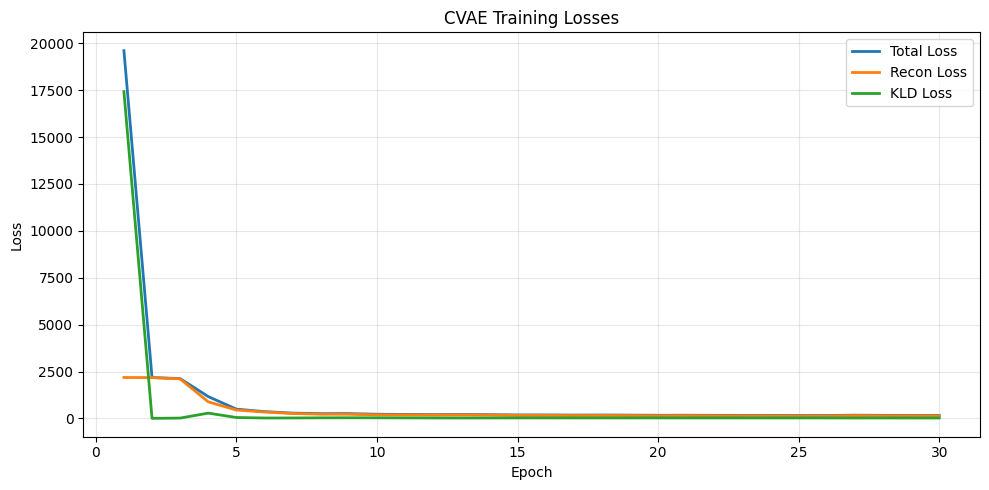

Saved hardtasklatentspaces.png


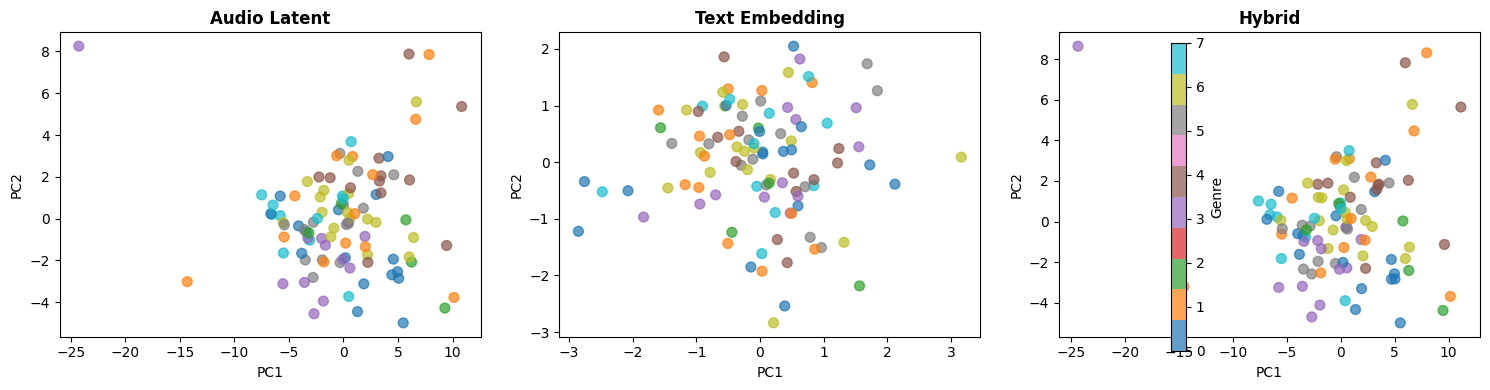

HARD TASK COMPLETED!
Saved files:
  hardtasktraininglosses.png  - Training loss curves
  hardtasklatentspaces.png    - 2D PCA projections
  hardtaskclusteringresults.csv - Metrics table
  tracks processed 100
  CVAE audio latent dim 32
  Text latent dim 32
  Hybrid latent dim 64


In [4]:
# ============================
# HARD TASK: Conv-CVAE + Hybrid Text/Audio
# ============================
import os, random, warnings
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# -------------------------
# CONFIGURATION
# -------------------------
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

ROOT = "/kaggle/input/fma-free-music-archive-small-medium"
FMA_AUDIO_DIR = os.path.join(ROOT, "fma_small", "fma_small")
FMA_TRACKS_CSV = os.path.join(ROOT, "fma_metadata", "tracks.csv")

MAX_TRACKS = 100  # hard task uses 100

SR = 22050
N_MELS = 128
N_FFT = 2048
HOP_LENGTH = 512
SPEC_LEN = 256  # time frames
LATENT_DIM_AUDIO = 32
TEXT_DIM_REDUCED = 32

TEXT_MODEL = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"

BATCH_SIZE = 16
EPOCHS = 30
LR = 1e-3
BETA = 1.0

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("TASK: Conditional VAE Multi-Modal Clustering on FMA Small")
print("device:", DEVICE)

# -------------------------
# PATH HELPERS
# -------------------------
def fma_audio_path(track_id, audiodir=FMA_AUDIO_DIR):
    track_id = int(track_id)
    subdir = f"{track_id:06d}"[:3]
    filename = f"{track_id:06d}.mp3"
    return os.path.join(audiodir, subdir, filename)

# -------------------------
# LOAD METADATA
# -------------------------
def load_fma_subset(max_tracks=MAX_TRACKS):
    print(f"Loading metadata from {FMA_TRACKS_CSV} ...")
    tracks = pd.read_csv(FMA_TRACKS_CSV, index_col=0, header=[0, 1])

    # keep only subset=small
    subset = tracks["set", "subset"] == "small"
    tracks_small = tracks[subset].copy()

    # flatten columns so we can index with single strings
    tracks_small.columns = ["{}_{}".format(a, b) for a, b in tracks_small.columns]

    # genre, title, artist as simple Series
    genretop = tracks_small["track_genre_top"]
    df = tracks_small.copy()
    df["genre_top"] = genretop
    df = df[df["genre_top"].notna()].copy()

    df["track_id"] = df.index.astype(int)
    df["title"] = tracks_small["track_title"].astype(str)
    df["artist"] = tracks_small["artist_name"].astype(str)
    df["text"] = df["title"] + " - " + df["artist"]  # now 1D Series + 1D Series

    # audio paths
    paths = []
    for tid in df["track_id"].tolist():
        p = fma_audio_path(tid)
        paths.append(p)
    df["audio_path"] = paths
    df = df[df["audio_path"].apply(os.path.exists)].copy()

    df = df.sample(frac=1.0, random_state=SEED).head(max_tracks).reset_index(drop=True)
    print(f"Using {len(df)} tracks with audio + genre_top.")
    print("Genre distribution:")
    print(df["genre_top"].value_counts())
    return df

# -------------------------
# AUDIO PREPROCESSING
# -------------------------
def load_mel_spectrogram(path, sr=SR, n_mels=N_MELS, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, spec_len=SPEC_LEN):
    y, sr = librosa.load(path, sr=sr, mono=True)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max)
    if mel_db.shape[1] < spec_len:
        pad_width = spec_len - mel_db.shape[1]
        mel_db = np.pad(mel_db, ((0, 0), (0, pad_width)), mode="constant")
    else:
        mel_db = mel_db[:, :spec_len]
    return mel_db.astype(np.float32)

class FMADataset(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
        self.specs = []
        self.labels = df["genre_top"].astype("category")
        self.genre_encoder = self.labels.cat
        self.label_ids = self.labels.cat.codes.values
        print("Computing mel-spectrograms (this may take a few minutes)...")
        for i, row in df.iterrows():
            if i % 20 == 0:
                print(f"{i:02d}/{len(df)} Processing...")
            spec = load_mel_spectrogram(row["audio_path"])
            self.specs.append(spec)
        self.specs = np.stack(self.specs, axis=0)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        spec = self.specs[idx]
        x = torch.from_numpy(spec).unsqueeze(0)  # (1, 128, 256)
        y = self.label_ids[idx]
        return x, y

# -------------------------
# CONDITIONAL VAE
# -------------------------
class ConditionalVAE(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM_AUDIO, num_classes=10):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # -> (16, 64, 128)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # -> (32, 32, 64)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # -> (64, 16, 32)
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),# -> (128, 8, 16)
            nn.ReLU(),
        )
        self.enc_out_shape = (128, 8, 16)
        enc_flat = 128 * 8 * 16
        self.fc_mu = nn.Linear(enc_flat + num_classes, latent_dim)
        self.fc_logvar = nn.Linear(enc_flat + num_classes, latent_dim)

        self.fc_dec = nn.Linear(latent_dim + num_classes, enc_flat)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
        )

        self.num_classes = num_classes

    def encode(self, x, y):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        y_onehot = torch.nn.functional.one_hot(y, num_classes=self.num_classes).float()
        h_cat = torch.cat([h, y_onehot], dim=1)
        mu = self.fc_mu(h_cat)
        logvar = self.fc_logvar(h_cat)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        y_onehot = torch.nn.functional.one_hot(y, num_classes=self.num_classes).float()
        z_cat = torch.cat([z, y_onehot], dim=1)
        h = self.fc_dec(z_cat)
        h = h.view(-1, *self.enc_out_shape)
        return self.dec(h)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mu, logvar, z

def cvae_loss_with_components(x_recon, x, mu, logvar, beta=1.0):
    recon = nn.functional.mse_loss(x_recon, x, reduction="mean")
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1)
    kld = torch.mean(kld)
    total = recon + beta * kld
    return total, recon.detach(), kld.detach()

def train_cvae(dataset):
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    num_classes = len(dataset.genre_encoder.categories)
    cvae = ConditionalVAE(latent_dim=LATENT_DIM_AUDIO, num_classes=num_classes).to(DEVICE)
    opt = torch.optim.Adam(cvae.parameters(), lr=LR)

    print("Training Conditional VAE...")
    total_losses, recon_losses, kld_losses = [], [], []

    for epoch in range(1, EPOCHS + 1):
        cvae.train()
        epoch_total = 0.0
        epoch_recon = 0.0
        epoch_kld = 0.0
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).long()  # <<< ensure LongTensor for one_hot

            opt.zero_grad()
            x_recon, mu, logvar, z = cvae(x, y)
            loss, recon, kld = cvae_loss_with_components(
                x_recon, x, mu, logvar, beta=BETA
            )
            loss.backward()
            opt.step()

            bs = x.size(0)
            epoch_total += loss.item() * bs
            epoch_recon += recon.item() * bs
            epoch_kld += kld.item() * bs

        num_samples = len(dataset)
        avg_total = epoch_total / num_samples
        avg_recon = epoch_recon / num_samples
        avg_kld = epoch_kld / num_samples
        total_losses.append(avg_total)
        recon_losses.append(avg_recon)
        kld_losses.append(avg_kld)

        if epoch == 1 or epoch % 5 == 0:
            print(
                f"Epoch {epoch:2d}/{EPOCHS:2d} - Total {avg_total:.4f}, "
                f"Recon {avg_recon:.4f}, KLD {avg_kld:.4f}"
            )

    print("Extracting audio latents from CVAE...")
    cvae.eval()
    all_latents = []
    with torch.no_grad():
        for x, y in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
            x = x.to(DEVICE)
            y = y.to(DEVICE).long()  # <<< same here for consistency
            mu, logvar = cvae.encode(x, y)
            all_latents.append(mu.cpu().numpy())
    Zaudio = np.concatenate(all_latents, axis=0)
    print("Audio latent shape", Zaudio.shape)
    return cvae, Zaudio, (total_losses, recon_losses, kld_losses)


# -------------------------
# TEXT EMBEDDINGS
# -------------------------
def compute_text_embeddings(df):
    print(f"Loading text model {TEXT_MODEL}")
    model = SentenceTransformer(TEXT_MODEL)
    texts = df["text"].astype(str).tolist()
    print(f"Embedding {len(texts)} texts...")
    emb = model.encode(texts, show_progress_bar=True, convert_to_numpy=True)
    print("Raw text embedding shape", emb.shape)
    scaler = StandardScaler()
    emb_scaled = scaler.fit_transform(emb)
    pca = PCA(n_components=TEXT_DIM_REDUCED, random_state=SEED)
    emb_pca = pca.fit_transform(emb_scaled)
    print("Reduced text embedding shape", emb_pca.shape)
    return emb_pca

# -------------------------
# CLUSTERING HELPERS
# -------------------------
def cluster_purity(labels_true, labels_pred):
    purity = 0
    for pred_label in np.unique(labels_pred):
        mask = labels_pred == pred_label
        true_labels_in_cluster = labels_true[mask]
        if len(true_labels_in_cluster) == 0:
            continue
        most_common = np.bincount(true_labels_in_cluster).max()
        purity += most_common
    return purity / len(labels_pred)

def evaluate_clustering_comprehensive(features, labels_true, desc):
    k = len(np.unique(labels_true))
    km = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels_pred = km.fit_predict(features)
    sil = silhouette_score(features, labels_pred)
    dbi = davies_bouldin_score(features, labels_pred)
    ari = adjusted_rand_score(labels_true, labels_pred)
    nmi = normalized_mutual_info_score(labels_true, labels_pred)
    purity = cluster_purity(labels_true, labels_pred)
    print(desc)
    print(f"  Silhouette {sil:.4f}, DBI {dbi:.4f}")
    print(f"  ARI {ari:.4f}, NMI {nmi:.4f}, Purity {purity:.4f}")
    return {
        "method": desc,
        "k": k,
        "silhouette": sil,
        "dbi": dbi,
        "ari": ari,
        "nmi": nmi,
        "purity": purity,
    }

def baseline_pca(data, labels_true, ncomponents=LATENT_DIM_AUDIO):
    print("Computing PCA baseline...")
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=ncomponents, random_state=SEED)
    Zpca = pca.fit_transform(data_scaled)
    print("PCA shape", Zpca.shape)
    return evaluate_clustering_comprehensive(Zpca, labels_true, "PCA")

class SimpleAutoencoder(nn.Module):
    def __init__(self, latent_dim=LATENT_DIM_AUDIO):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
        )
        self.enc_out_shape = (128, 8, 16)
        enc_flat = 128 * 8 * 16
        self.fc_enc = nn.Linear(enc_flat, latent_dim)
        self.fc_dec = nn.Linear(latent_dim, enc_flat)
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, 2, 1),
        )

    def encode(self, x):
        h = self.enc(x)
        h = h.view(h.size(0), -1)
        return self.fc_enc(h)

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, *self.enc_out_shape)
        return self.dec(h)

    def forward(self, x):
        z = self.encode(x)
        x_recon = self.decode(z)
        return x_recon, z

def train_autoencoder(dataset):
    print("Training Standard Autoencoder baseline...")
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
    ae = SimpleAutoencoder(latent_dim=LATENT_DIM_AUDIO).to(DEVICE)
    opt = torch.optim.Adam(ae.parameters(), lr=LR)
    for epoch in range(1, EPOCHS + 1):
        ae.train()
        total = 0.0
        for x, _ in loader:
            x = x.to(DEVICE)
            opt.zero_grad()
            x_recon, z = ae(x)
            loss = nn.functional.mse_loss(x_recon, x)
            loss.backward()
            opt.step()
            total += loss.item() * x.size(0)
        avg = total / len(dataset)
        if epoch == 1 or epoch % 5 == 0:
            print(f"Epoch {epoch:2d}/{EPOCHS:2d} - Loss {avg:.4f}")
    print("Extracting autoencoder latents...")
    ae.eval()
    all_latents = []
    with torch.no_grad():
        for x, _ in DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False):
            x = x.to(DEVICE)
            _, z = ae(x)
            all_latents.append(z.cpu().numpy())
    Zae = np.concatenate(all_latents, axis=0)
    print("Autoencoder latent shape", Zae.shape)
    return Zae

# -------------------------
# VISUALIZATION
# -------------------------
def visualise_latent_space(Zaudio, Ztext, Zhybrid, labels_true, genrenames):
    pca2d = PCA(n_components=2, random_state=SEED)
    Zaudio2d = pca2d.fit_transform(Zaudio)
    Ztext2d = pca2d.fit_transform(Ztext)
    Zhybrid2d = pca2d.fit_transform(Zhybrid)

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for ax, Z2d, title in zip(
        axes,
        [Zaudio2d, Ztext2d, Zhybrid2d],
        ["Audio Latent", "Text Embedding", "Hybrid"],
    ):
        sc = ax.scatter(
            Z2d[:, 0],
            Z2d[:, 1],
            c=labels_true,
            cmap="tab10",
            s=50,
            alpha=0.7,
        )
        ax.set_title(title, fontsize=12, fontweight="bold")
        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
    plt.colorbar(sc, ax=axes, label="Genre")
    plt.tight_layout()
    plt.savefig("hardtasklatentspaces.png", dpi=100, bbox_inches="tight")
    print("Saved hardtasklatentspaces.png")
    plt.show()   # ensure inline figure
    plt.close()

def plot_training_losses(loss_history):
    totallosses, reconlosses, kldlosses = loss_history
    epochs = np.arange(1, len(totallosses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, totallosses, label="Total Loss", linewidth=2)
    plt.plot(epochs, reconlosses, label="Recon Loss", linewidth=2)
    plt.plot(epochs, kldlosses, label="KLD Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("CVAE Training Losses")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig("hardtasktraininglosses.png", dpi=150, bbox_inches="tight")
    print("Saved hardtasktraininglosses.png")
    plt.show()   # ensure inline figure
    plt.close()

# -------------------------
# MAIN HARD-TASK PIPELINE
# -------------------------
def main():
    print("=" * 80)
    print("HARD TASK: Conv-VAE Hybrid Audio+Text Clustering on FMA Small")
    print("=" * 80)

    # 1. Load metadata
    df = load_fma_subset(MAX_TRACKS)
    genre_names = df["genre_top"].astype("category").cat.categories.tolist()
    labels_true = pd.Categorical(df["genre_top"]).codes

    # 2. Audio dataset
    dataset = FMADataset(df)
    num_classes = len(dataset.genre_encoder.categories)
    print("Number of classes:", num_classes)

    # 3. Train Conditional VAE
    cvae, Zaudio, loss_history = train_cvae(dataset)

    # 4. Compute text embeddings
    Ztext = compute_text_embeddings(df)

    # 5. Build hybrid features
    print("Building hybrid feature representation...")
    Zaudionorm = StandardScaler().fit_transform(Zaudio)
    Ztextnorm = StandardScaler().fit_transform(Ztext)
    Zhybrid = np.concatenate([Zaudionorm, Ztextnorm], axis=1)
    print("Hybrid feature shape", Zhybrid.shape)

    # 6. Baselines
    results = []
    print("=" * 80)
    print("BASELINE: PCA")
    print("=" * 80)
    specs_flat = dataset.specs.reshape(len(dataset.specs), -1)
    results.append(baseline_pca(specs_flat, labels_true, ncomponents=LATENT_DIM_AUDIO))

    print("=" * 80)
    print("BASELINE: Standard Autoencoder")
    print("=" * 80)
    Zae = train_autoencoder(dataset)
    results.append(evaluate_clustering_comprehensive(Zae, labels_true, "Autoencoder"))

    # 7. Main methods
    print("=" * 80)
    print("MAIN METHODS: Conditional VAE & Hybrid")
    print("=" * 80)
    results.append(evaluate_clustering_comprehensive(Zaudionorm, labels_true, "CVAE Audio"))
    results.append(evaluate_clustering_comprehensive(Ztextnorm, labels_true, "Text Embedding"))
    results.append(evaluate_clustering_comprehensive(Zhybrid, labels_true, "CVAE Text Hybrid"))

    # 8. Summary
    resdf = pd.DataFrame(results)
    print("=" * 80)
    print("COMPREHENSIVE SUMMARY (sorted by Silhouette Score)")
    print("=" * 80)
    summary = resdf.sort_values("silhouette", ascending=False)
    print(summary[["method", "silhouette", "dbi", "ari", "nmi", "purity"]].to_string(index=False))
    resdf.to_csv("hardtaskclusteringresults.csv", index=False)

    # 9. Visualizations
    print("=" * 80)
    print("VISUALIZATION")
    print("=" * 80)
    plot_training_losses(loss_history)
    visualise_latent_space(Zaudionorm, Ztextnorm, Zhybrid, labels_true, genre_names)

    print("=" * 80)
    print("HARD TASK COMPLETED!")
    print("=" * 80)
    print("Saved files:")
    print("  hardtasktraininglosses.png  - Training loss curves")
    print("  hardtasklatentspaces.png    - 2D PCA projections")
    print("  hardtaskclusteringresults.csv - Metrics table")
    print(f"  tracks processed {len(df)}")
    print(f"  CVAE audio latent dim {Zaudio.shape[1]}")
    print(f"  Text latent dim {Ztext.shape[1]}")
    print(f"  Hybrid latent dim {Zhybrid.shape[1]}")

if __name__ == "__main__":
    main()
